In [ ]:
!pip install git+https://github.com/NHERI-SimCenter/BrailsPlusPlus

  Cloning https://github.com/NHERI-SimCenter/BrailsPlusPlus to /tmp/pip-req-build-pf11y6ta
  Running command git clone --filter=blob:none --quiet https://github.com/NHERI-SimCenter/BrailsPlusPlus /tmp/pip-req-build-pf11y6ta
  Resolved https://github.com/NHERI-SimCenter/BrailsPlusPlus to commit b7c08a57fc00e3694946ffe2753e696104295cb3
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.0/43.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 50.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.7/254.7 kB 18.1 MB/s eta 0:00:00
  Created wheel for brails: filename=brails-2.0-py3-none-any.whl size=256427 sha256=111f33ce18141c3c8da07085ef9904b89ce2ae930ccf51ba9742985f1e323cf

In [ ]:
import gdown
import os
import shutil
from tqdm import tqdm

from brails.utils import Importer
from brails.processors.vlm_segmenter.grounded_sam_utils import build_models, run_on_one_image
from brails.utils.segmentation_utils import create_overlaid_image

In [ ]:
fileURL = 'https://drive.google.com/uc?export=download&id=1B-IjAD6ZLn8jJt45nYjl_cVtjGutaPYG'

fileOut = "dataset.zip"
gdown.download(fileURL, fileOut, quiet=False)

Downloading...
From: https://drive.google.com/uc?export=download&id=1B-IjAD6ZLn8jJt45nYjl_cVtjGutaPYG
To: /content/dataset.zip
100%|██████████| 8.97M/8.97M [00:00<00:00, 51.8MB/s]


'dataset.zip'

In [ ]:
!unzip dataset.zip -d dataset
data_path = 'dataset/bldgSeg'

Archive:  dataset.zip
replace dataset/bldgSeg/valid/masks/78_mask.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------------------------------------------------------
Epoch: 1/3
100%|██████████| 8/8 [00:12<00:00,  1.52s/it]
train loss:  0.2894, valid loss:  0.2437, train f1-score:  0.5762, valid f1-score:  0.5863, 

------------------------------------------------------------
Epoch: 2/3
100%|██████████| 8/8 [00:12<00:00,  1.51s/it]
train loss:  0.1790, valid loss:  0.1868, train f1-score:  0.5908, valid f1-score:  0.5751, 

------------------------------------------------------------
Epoch: 3/3
100%|██████████| 8/8 [00:13<00:00,  1.73s/it]
train loss:  0.1347, valid loss:  0.1320, train f1-score:  0.5915, valid f1-score:  0.5807, 

------------------------------------------------------------
Training completed in 8m 7s
Lowest validation loss:  0.1320
Training complete.


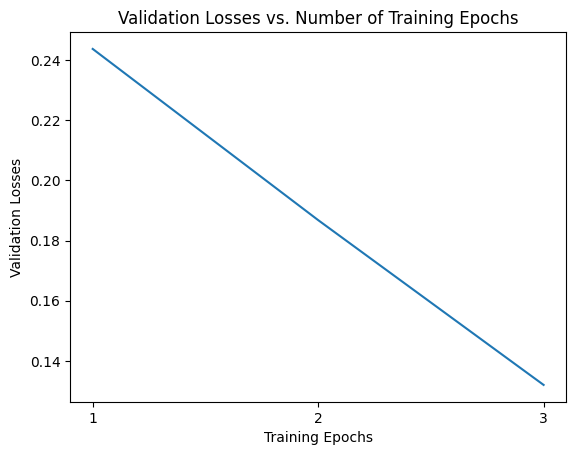

In [ ]:
importer = Importer()
myclass = importer.get_class('ImageSegmenter')
imsegmenter = myclass()

seg_classes = ["facade","roof","window","door"]
imsegmenter.train(train_data_dir=data_path,
                  classes=seg_classes,
                  nepochs=3)

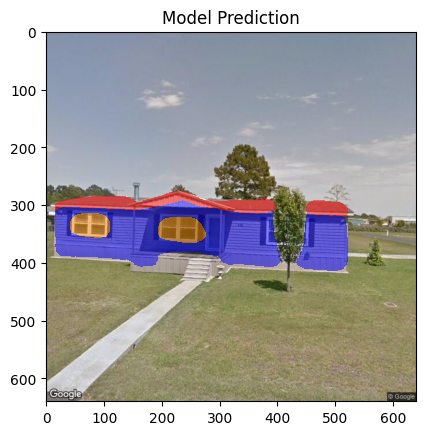

In [ ]:
%matplotlib inline
imno = 6

imPath = data_path + '/valid/images/'
imList = os.listdir(imPath)

imsegmenter.predict(imdir=imPath + imList[imno],classes=["facade","roof","window","door"])

In [ ]:
url = "https://drive.google.com/uc?id=1pr4zIK0D8wRsa6npWRD5h93r0eJglbTP"
output = "additional_imagery.zip"
gdown.download(url, output, quiet=False)

im_dir = 'additional_images/'

Downloading...
From: https://drive.google.com/uc?id=1pr4zIK0D8wRsa6npWRD5h93r0eJglbTP
To: /content/additional_imagery.zip
100%|██████████| 7.06M/7.06M [00:00<00:00, 37.7MB/s]


'additional_imagery.zip'

In [ ]:
!unzip additional_imagery.zip

Archive:  additional_imagery.zip
replace additional_images/imstreet_32.77248357-117.25226047.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
output_dir_masks = 'segmented_images/'
output_dir_overlaid = 'overlaid_images/'

im_files = os.listdir(im_dir)
images = [im_dir + im for im in im_files]


grounding_dino_model, sam_predictor = build_models()
for image in tqdm(images):
    pixel_mask, mask_path = run_on_one_image(image, output_dir_masks,
                                             grounding_dino_model,
                                             sam_predictor,
                                             seg_classes)
    create_overlaid_image(image, pixel_mask, output_dir_overlaid)

DEVICE FOUND: cuda
final text_encoder_type: bert-base-uncased


  0%|          | 0/50 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/1.64k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/689M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/457 [00:00<?, ?B/s]

100%|██████████| 50/50 [04:50<00:00,  5.80s/it]


In [ ]:
im_keep = []

shutil.copy(im_dir + im, data_path + '/train/images/' + im)
mask = im.replace('.png','_mask.png')
shutil.copy(output_dir_masks + mask, data_path + '/train/masks/' + im)
